# f) Ngonye Falls Power and Energy Periods
Produces summary, agrregated results from the daily power and energy modelling.


## Inputs

| Data                       | Source                                        | Description                                 |
|----------------------------|-----------------------------------------------|---------------------------------------------|
| [Model Name]_pe_daily.csv | Notebook: e_power_energy | Daily power output  |


## Outputs
| File                           | Description                                 |
|--------------------------------|---------------------------------------------|
|    [Model Name]_pe_daily.csv ||
|    [Model Name]_pe_monthly.csv||
|    [Model Name]_pe_yearly.csv||
|    [Model Name]_pe_percentiles.csv||
|    [Model Name]_pe_monthly_day.csv||
|    [Model Name]_pe_daily_slim.csv||
|    [Model Name]_pe_weekly.csv||
|    [Model Name]_pe_weekly_slim.csv||
|    [Model Name]_pe_calmonthly.csv||
|    [Model Name]_pe_fdc.csv||
|    [Model Name]_pe_power_exceed.csv||
|    models.csv| |

## Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import math
import statsmodels.tsa.stattools as statools

## Parameters

In [2]:
input_data='./input_data/'
output_data='./output_data/'

In [3]:
model_name='Base Case'#MW153#MW144 'MW162'#'Fixed Tailwater'#'Base Case' Headpond50cm EWRAllCs
dryrun=False #Dont write output files

In [4]:
models=pd.read_csv(input_data + "models.csv").set_index('ModelName')
model=models.loc[model_name]

out_prefix=model['OutputPrefix']#'base'
if out_prefix!='base':
    out_prefix="scenarios/" + out_prefix
    
plant_capacity=model['Capacity']#180
canal_capacity=plant_capacity/180*1100#1100

model

OutputPrefix                  base
Description              Base Case
EWRCatSet         Recommendation 1
HeadpondLift                     0
Capacity                       180
FixedTailwater                   0
Mean                        832123
P95                         717411
P90                         754939
P75                         791547
P50                         838318
P25                         875947
P10                         921510
P5                          957737
StDev                      82094.8
CoefVar                  0.0986571
Max                    1.01828e+06
Min                         493500
CapFactor                 0.527729
CalYearMean                 832218
CalYearStDev               78428.1
CalYearCoefVar           0.0942398
AutoCorrel                     NaN
Name: Base Case, dtype: object

## Load Daily Data

Load the daily time series which includes the exceedance values used for calculating daily EWRs.

In [5]:
daily=pd.read_csv(output_data+out_prefix+'_pe_daily.csv')
daily=daily.set_index(pd.to_datetime(daily['Date'],format="%Y-%m-%d"))
daily=daily.drop('Date',axis=1)
daily.head(5)

,LaggedDate,VicFalls,Conversion,Flow,Exceedance,Year,Month,Day,MonthId,WaterYear,...,EffGen3,EffGen4,PowerTurbine1,PowerTurbine2,PowerTurbine3,PowerTurbine4,Power,Energy,PerfMwPerCumec,ExceedanceRnd
Date,,,,,,,,,,,,,,,,,,,,,
1924-10-01,1924-10-12,100.0,1.111331,111.133124,0.999,1924,10,1,1924.1,1924,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1924-10-02,1924-10-13,100.0,1.111331,111.133124,0.999,1924,10,2,1924.1,1924,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1924-10-03,1924-10-14,100.0,1.111331,111.133124,0.999,1924,10,3,1924.1,1924,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1924-10-04,1924-10-15,100.0,1.111331,111.133124,0.999,1924,10,4,1924.1,1924,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1924-10-05,1924-10-16,100.0,1.111331,111.133124,0.999,1924,10,5,1924.1,1924,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0


## Monthly


In [6]:

monthly=daily.groupby("MonthId").mean().drop(['VicFalls','Conversion','Day','WaterDay','WaterWeek','Volume','EWRBandNo','EWRRefExceedance','Energy'],axis=1)

monthly=monthly.join(daily.groupby("MonthId").agg(    
   Power_max=('Power', 'max'),
   Power_min=('Power', 'min'),   
   Turbines_max=('Turbines', 'max'),    
   Turbines_min=('Turbines', 'min'),   
   Energy=('Energy', 'sum'),
))
monthly['Days']=monthly.apply(lambda x: pd.Period(year=x['Year'],month=x['Month'],freq='D').days_in_month,axis=1)
monthly['CapFactor']=monthly['Energy']/(plant_capacity*24*monthly['Days'])

monthly.tail(12)

,Flow,Exceedance,Year,Month,WaterYear,WaterMonth,EWRChannelA,EWRChannelC,EWRChannelD,EWRChannelE,...,Power,PerfMwPerCumec,ExceedanceRnd,Power_max,Power_min,Turbines_max,Turbines_min,Energy,Days,CapFactor
MonthId,,,,,,,,,,,,,,,,,,,,,
2016.10,186.117272,0.973290,2016.0,10.0,2016.0,1.0,31.000000,4.000000,3.000000,2.000000,...,24.332111,0.130268,0.971613,29.616807,19.265120,1,1,18103.090598,31,0.135178
2016.11,186.562065,0.968767,2016.0,11.0,2016.0,2.0,25.000000,4.000000,2.000000,2.000000,...,28.458823,0.150451,0.967667,39.837904,18.354687,1,1,20490.352445,30,0.158105
2016.12,369.487694,0.701516,2016.0,12.0,2016.0,3.0,29.387097,4.677419,3.000000,2.000000,...,64.627935,0.174405,0.700645,106.746810,39.575231,2,1,48083.183741,31,0.359044
2017.01,851.896141,0.394581,2017.0,1.0,2016.0,4.0,44.387097,6.677419,5.354839,3.677419,...,139.045177,0.162158,0.393548,177.265268,67.172040,4,2,103449.611851,31,0.772473
2017.02,1236.957587,0.273679,2017.0,2.0,2016.0,5.0,49.000000,8.000000,7.000000,5.000000,...,181.200095,0.148101,0.273929,192.306328,171.035855,4,4,121766.464031,28,1.006667
2017.03,2420.771572,0.145774,2017.0,3.0,2016.0,6.0,49.000000,9.000000,9.000000,9.000000,...,155.279968,0.075089,0.146129,181.298207,117.687033,4,4,115528.295911,31,0.862666
2017.04,3419.680887,0.063633,2017.0,4.0,2016.0,7.0,70.000000,14.000000,18.000000,25.000000,...,127.885591,0.038018,0.063333,142.568515,116.887838,4,4,92077.625765,30,0.710476
2017.05,2194.251076,0.156387,2017.0,5.0,2016.0,8.0,55.000000,13.000000,13.000000,17.000000,...,160.362747,0.075410,0.155806,177.436189,144.100481,4,4,119309.883944,31,0.890904
2017.06,1117.935234,0.312067,2017.0,6.0,2016.0,9.0,53.000000,12.000000,12.000000,13.000000,...,156.045711,0.141604,0.313333,188.863966,95.686797,4,2,112352.912049,30,0.866921


## Yearly

In [7]:
yearly=daily.groupby("WaterYear").agg(
   Flow_max=('Flow', 'max'),
   Flow_min=('Flow', 'min'), 
   EWRProportion_max=('EWRProportion', 'max'),
   EWRProportion_min=('EWRProportion', 'min'),
   HeadTurbine1_max=('HeadTurbine1', 'max'),
   HeadTurbine1_min=('HeadTurbine1', 'min'),    
   LevelTailwater_max=('LevelTailwater', 'max'),
   LevelTailwater_min=('LevelTailwater', 'min'),  
   Power_max=('Power', 'max'),
   Power_min=('Power', 'min'),    
   Energy=('Energy', 'sum'),
)
yearly['CapFactor']=yearly['Energy']/(plant_capacity*24*365)


In [8]:
yearly['Prop4Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==4,1,0))/365)
yearly['Prop3Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==3,1,0))/365)
yearly['Prop2Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==2,1,0))/365)
yearly['Prop1Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==1,1,0))/365)
yearly['Prop0Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==0,1,0))/365)
yearly['Days0Units']=daily[['WaterYear','Turbines']].groupby('WaterYear').agg(lambda x: sum(np.where(x==0,1,0)))


## Power and energy exceedance

In [9]:
power_exceed=pd.DataFrame(index=np.arange(0,1.05,0.05))
power_exceed.index=power_exceed.index.rename('Exceedance')
power_exceed['Power']=np.percentile(daily['Power'],(1-power_exceed.index)*100)
power_exceed.head(3)

,Power
Exceedance,
0.00,193.747347
0.05,181.706156
0.10,173.379605


In [10]:
edc=pd.DataFrame(index=np.arange(0,1.05,0.05))
edc['Energy']=np.percentile(yearly['Energy'],(1-edc.index)*100)

edc.head(3)

,Energy
0.00,1.018276e+06
0.05,9.577369e+05
0.10,9.215099e+05


In [11]:
yearly['Exceedance']=pd.merge_asof(yearly.reset_index().sort_values('Energy'),edc.reset_index().sort_values('Energy'),left_on='Energy',right_on='Energy').set_index('WaterYear')['index']

## Calendar years
Jan-Dec rather than Oct-Sept

In [12]:
calyearly=daily.groupby("Year").agg(  
   Energy=('Energy', 'sum'),
).drop([1924,2017],axis=0)
calyearly['CapFactor']=calyearly['Energy']/(180*24*365)
calyearly.head(5)

,Energy,CapFactor
Year,,
1925,853834.972289,0.541499
1926,777044.104101,0.492798
1927,853200.496589,0.541096
1928,829378.408235,0.525988
1929,753348.824234,0.477771


## Monthly Day
15th of every month

In [13]:
monthly_day=daily.loc[daily['Day']==15]

## Daily Slim
Slim has less columns and values are rounded so file size is reduced

In [14]:
daily_slim=daily.loc[:,
                     ['Year',
                      'Month',
                      'Day',
                      'WaterYear',
                      'Flow',
                      'EWRRefExceedance',
                      'EWRBandNo',
                      'EWRChannelA',
                      'EWRChannelC',
                      'EWRChannelD',
                      'EWRChannelE',
                      'EWRChannelFG',
                      'EWRTotal',
                      'EWRProportion',
                      'FlowCanal',
                      'FlowSpill',
                      'SpillChannelA',
                      'SpillChannelC',
                      'SpillChannelD',
                      'SpillChannelE',
                      'SpillChannelFG',
                      'FlowChannelA',
                      'FlowChannelC',
                      'FlowChannelD',
                      'FlowChannelE',
                      'FlowChannelFG',
                      'FlowLeftChannel',
                      'FlowTurbine1',
                      'FlowTurbine2',
                      'FlowTurbine3',
                      'FlowTurbine4',
                      'LevelHeadpond',
                      'LevelTailwater',
                      'HeadlossLeftChannel',
                      'HeadlossCanal',
                      'LevelForebay',
                      'Turbines',
                      'HeadTurbine1',
                      'HeadTurbine2',
                      'HeadTurbine3',
                      'HeadTurbine4',
                      'EffTurbine1',
                      'EffTurbine2',
                      'EffTurbine3',
                      'EffTurbine4',
                      'PowerTurbine1',
                      'PowerTurbine2',
                      'PowerTurbine3',
                      'PowerTurbine4',
                      'Power',
                      'Energy'
                     ]
                    ].fillna(0).astype({
                        'Flow': 'int32',
                        'FlowCanal': 'int32',
                        'FlowSpill': 'int32',
                        'EWRChannelA': 'int32',
                        'EWRChannelC': 'int32',
                        'EWRChannelD': 'int32',    
                        'EWRChannelE': 'int32',
                        'EWRChannelFG': 'int32',
                        'EWRTotal': 'int32',    
                        'SpillChannelA': 'int32',
                        'SpillChannelC': 'int32',
                        'SpillChannelD': 'int32',    
                        'SpillChannelE': 'int32',
                        'SpillChannelFG': 'int32',
                        'FlowChannelA': 'int32',
                        'FlowChannelC': 'int32',
                        'FlowChannelD': 'int32',    
                        'FlowChannelE': 'int32',
                        'FlowChannelFG': 'int32',
                        'FlowLeftChannel': 'int32',
                        'FlowTurbine1': 'int32',
                        'FlowTurbine2': 'int32',
                        'FlowTurbine3': 'int32',
                        'FlowTurbine4': 'int32',
                        'Energy': 'int32',
                        
                    }).round({
                            'EWRProportion': 2,
                            'LevelHeadpond': 1,
                            'LevelTailwater': 1,
                            'HeadlossLeftChannel': 2,
                            'HeadlossCanal': 2,
                            'LevelForebay': 1,
                            'PowerTurbine1': 1,
                            'PowerTurbine2': 1,
                            'PowerTurbine3': 1,
                            'PowerTurbine4': 1,
                            'Power': 1,
                            'HeadTurbine1':1,
                            'HeadTurbine2':1,
                            'HeadTurbine3':1,
                            'HeadTurbine4':1,
                            'EffTurbine1':2,
                            'EffTurbine2':2,
                            'EffTurbine3':2,
                            'EffTurbine4':2,    
                    })
daily_slim.tail(12)

,Year,Month,Day,WaterYear,Flow,EWRRefExceedance,EWRBandNo,EWRChannelA,EWRChannelC,EWRChannelD,...,EffTurbine1,EffTurbine2,EffTurbine3,EffTurbine4,PowerTurbine1,PowerTurbine2,PowerTurbine3,PowerTurbine4,Power,Energy
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-19,2017,9,19,2016,216,0.81,4,34,6,4,...,0.91,0.0,0.0,0.0,27.2,0.0,0.0,0.0,27.2,653
2017-09-20,2017,9,20,2016,213,0.81,4,34,6,4,...,0.91,0.0,0.0,0.0,26.5,0.0,0.0,0.0,26.5,636
2017-09-21,2017,9,21,2016,213,0.82,4,34,6,4,...,0.91,0.0,0.0,0.0,26.5,0.0,0.0,0.0,26.5,636
2017-09-22,2017,9,22,2016,209,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,25.5,0.0,0.0,0.0,25.5,611
2017-09-23,2017,9,23,2016,203,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,23.9,0.0,0.0,0.0,23.9,572
2017-09-24,2017,9,24,2016,203,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,23.8,0.0,0.0,0.0,23.8,572
2017-09-25,2017,9,25,2016,203,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,23.8,0.0,0.0,0.0,23.8,572
2017-09-26,2017,9,26,2016,203,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,23.8,0.0,0.0,0.0,23.8,572
2017-09-27,2017,9,27,2016,203,0.82,4,34,6,4,...,0.90,0.0,0.0,0.0,23.8,0.0,0.0,0.0,23.8,572


## Weekly & Weekly Slim
Slim has less columns and values are rounded so file size is reduced

In [15]:
weekly=daily.groupby(["WaterYear","WaterWeek"]).mean().drop(['Month','Year','MonthId','WaterMonth','VicFalls','Conversion','Day','WaterDay','Volume','EWRBandNo','EWRRefExceedance','Turbines','Energy'],axis=1)
weekly=weekly.join(daily.groupby(["WaterYear","WaterWeek"]).agg(    
   Flow_max=('Flow', 'max'),
   Flow_min=('Flow', 'min'), 
   EWRProportion_max=('EWRProportion', 'max'),
   EWRProportion_min=('EWRProportion', 'min'),
   HeadTurbine1_max=('HeadTurbine1', 'max'),
   HeadTurbine1_min=('HeadTurbine1', 'min'),    
   LevelTailwater_max=('LevelTailwater', 'max'),
   LevelTailwater_min=('LevelTailwater', 'min'),  
   Power_max=('Power', 'max'),
   Power_min=('Power', 'min'),    
   Energy=('Energy', 'sum'),
))
weekly=weekly.join(daily[["WaterYear","WaterWeek","Flow"]].groupby(["WaterYear","WaterWeek"]).count().rename(columns={'Flow':'Count'}))
weekly['CapFactor']=weekly['Energy']/(180*24*weekly['Count'])
weekly=weekly.join(daily.reset_index('Date')[["WaterYear","WaterWeek","Date"]].groupby(["WaterYear","WaterWeek"]).first().rename(columns={'Date':'StartDate'}))

weekly.tail(12)

Flow  Exceedance  EWRChannelA  EWRChannelC  \
WaterYear WaterWeek                                                     
2016      42         451.673869    0.594143    50.000000    10.000000   
          43         411.631943    0.638429    50.000000    10.000000   
          44         377.984000    0.677571    43.714286     8.285714   
          45         345.089425    0.718000    39.000000     7.000000   
          46         322.320457    0.753571    39.000000     7.000000   
          47         296.353596    0.789429    39.000000     7.000000   
          48         272.698436    0.833000    38.285714     6.857143   
          49         250.364895    0.874143    34.000000     6.000000   
          50         228.116819    0.912143    34.000000     6.000000   
          51         215.508577    0.932000    34.000000     6.000000   
          52         203.039212    0.949714    34.000000     6.000000   
          53         198.229576    0.958000    34.000000     6.000000   

                     EWRChannelD  EWRChannelE  EWRChannelFG    EWRTotal  \
WaterYear WaterWeek                                                       
2016      42            9.000000     9.000000    108.000000  186.000000   
          43            9.000000     9.000000    108.000000  186.000000   
          44            6.714286     6.142857     80.571429  145.428571   
          45            5.000000     4.000000     60.000000  115.000000   
          46            5.000000     4.000000     60.000000  115.000000   
          47            5.000000     4.000000     60.000000  115.000000   
          48            4.857143     3.857143     57.714286  111.571429   
          49            4.000000     3.000000     44.000000   91.000000   
          50            4.000000     3.000000     44.000000   91.000000   
          51            4.000000     3.000000     44.000000   91.000000   
          52            4.000000     3.000000     44.000000   91.000000   
          53            4.000000     3.000000     44.000000   91.000000   

                     EWRProportion   FlowCanal  ...  HeadTurbine1_max  \
WaterYear WaterWeek                             ...                     
2016      42              0.412191  265.673869  ...         24.154500   
          43              0.452114  225.631943  ...         24.263769   
          44              0.383130  232.555429  ...         24.397698   
          45              0.333428  230.089425  ...         24.512254   
          46              0.357011  207.320457  ...         24.680765   
          47              0.388246  181.353596  ...         24.815893   
          48              0.408941  161.127008  ...         24.936125   
          49              0.363667  159.364895  ...         24.990447   
          50              0.399211  137.116819  ...         25.067046   
          51              0.422374  124.508577  ...         25.096632   
          52              0.448189  112.039212  ...         25.111062   
          53              0.459064  107.229576  ...         25.426292   

                     HeadTurbine1_min  LevelTailwater_max  LevelTailwater_min  \
WaterYear WaterWeek                                                             
2016      42                23.851344          965.578247          965.399573   
          43                24.039147          965.383886          965.265004   
          44                24.170282          965.240711          965.106315   
          45                24.350218          965.085857          965.005058   
          46                24.528270          964.997026          964.920026   
          47                24.695029          964.912737          964.851233   
          48                24.825439          964.846410          964.785468   
          49                24.895196          964.781163          964.740304   
          50                25.009894          964.732714          964.713477   
          51                25.067046  

In [16]:
weekly_slim=weekly.loc[:,
                     [
                      'StartDate',
                      'Flow',
                      'EWRChannelA',
                      'EWRChannelC',
                      'EWRChannelD',
                      'EWRChannelE',
                      'EWRChannelFG',
                      'EWRTotal',
                      'EWRProportion',
                      'FlowCanal',
                      'FlowSpill',
                      'SpillChannelA',
                      'SpillChannelC',
                      'SpillChannelD',
                      'SpillChannelE',
                      'SpillChannelFG',
                      'FlowChannelA',
                      'FlowChannelC',
                      'FlowChannelD',
                      'FlowChannelE',
                      'FlowChannelFG',
                      'FlowLeftChannel',
                      'FlowTurbine1',
                      'FlowTurbine2',
                      'FlowTurbine3',
                      'FlowTurbine4',
                      'LevelHeadpond',
                      'LevelTailwater',
                      'HeadlossLeftChannel',
                      'HeadlossCanal',
                      'LevelForebay',
                      'HeadTurbine1',
                      'HeadTurbine2',
                      'HeadTurbine3',
                      'HeadTurbine4',
                      'EffTurbine1',
                      'EffTurbine2',
                      'EffTurbine3',
                      'EffTurbine4',
                      'PowerTurbine1',
                      'PowerTurbine2',
                      'PowerTurbine3',
                      'PowerTurbine4',
                      'Power',
                      'Energy'
                     ]
                    ].fillna(0).astype({
                        'Flow': 'int32',
                        'FlowCanal': 'int32',
                        'FlowSpill': 'int32',
                        'EWRChannelA': 'int32',
                        'EWRChannelC': 'int32',
                        'EWRChannelD': 'int32',    
                        'EWRChannelE': 'int32',
                        'EWRChannelFG': 'int32',
                        'EWRTotal': 'int32',
                        'SpillChannelA': 'int32',
                        'SpillChannelC': 'int32',
                        'SpillChannelD': 'int32',    
                        'SpillChannelE': 'int32',
                        'SpillChannelFG': 'int32',
                        'FlowChannelA': 'int32',
                        'FlowChannelC': 'int32',
                        'FlowChannelD': 'int32',    
                        'FlowChannelE': 'int32',
                        'FlowChannelFG': 'int32',
                        'FlowLeftChannel': 'int32',
                        'FlowTurbine1': 'int32',
                        'FlowTurbine2': 'int32',
                        'FlowTurbine3': 'int32',
                        'FlowTurbine4': 'int32',
                        'Energy': 'int32',
                        
                    }).round({
                            'EWRProportion':2,
                            'LevelHeadpond': 1,
                            'LevelTailwater': 1,
                            'HeadlossLeftChannel': 2,
                            'HeadlossCanal': 2,
                            'LevelForebay': 1,
                            'PowerTurbine1': 1,
                            'PowerTurbine2': 1,
                            'PowerTurbine3': 1,
                            'PowerTurbine4': 1,
                            'Power': 1,
                            'HeadTurbine1':1,
                            'HeadTurbine2':1,
                            'HeadTurbine3':1,
                            'HeadTurbine4':1,
                            'EffTurbine1':2,
                            'EffTurbine2':2,
                            'EffTurbine3':2,
                            'EffTurbine4':2,
                    })

## Calendar Months

In [17]:
calmonthly=pd.DataFrame({'WaterMonth': [1,2,3,4,5,6,7,8,9,10,11,12],'MonthName': ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'], 'Month':[10,11,12,1,2,3,4,5,6,7,8,9]})
calmonthly=calmonthly.set_index('WaterMonth')
calmonthly=calmonthly.join(monthly.groupby(["WaterMonth"]).agg(    
   EWRProportion_max=('EWRProportion', 'max'),
   EWRProportion_mean=('EWRProportion', 'mean'),
   EWRProportion_median=('EWRProportion', 'median'),
   EWRProportion_min=('EWRProportion', 'min'),
    
    EWRTotal_max=('EWRTotal', 'max'),
   EWRTotal_mean=('EWRTotal', 'mean'),
   EWRTotal_median=('EWRTotal', 'median'),
   EWRTotal_min=('EWRTotal', 'min'),   
    
   FlowCanal_max=('FlowCanal', 'max'),
   FlowCanal_mean=('FlowCanal', 'mean'),
   FlowCanal_median=('FlowCanal', 'median'),
   FlowCanal_min=('FlowCanal', 'min'),     
    
   HeadTurbine1_max=('HeadTurbine1', 'max'),
   HeadTurbine1_mean=('HeadTurbine1', 'mean'),
   HeadTurbine1_median=('HeadTurbine1', 'median'),
   HeadTurbine1_min=('HeadTurbine1', 'min'), 

   LevelTailwater_max=('LevelTailwater', 'max'),
   LevelTailwater_mean=('LevelTailwater', 'mean'),    
   LevelTailwater_median=('LevelTailwater', 'median'),    
   LevelTailwater_min=('LevelTailwater', 'min'),  
   LevelHeadpond_max=('LevelHeadpond', 'max'),
   LevelHeadpond_mean=('LevelHeadpond', 'mean'),    
   LevelHeadpond_median=('LevelHeadpond', 'median'),    
   LevelHeadpond_min=('LevelHeadpond', 'min'),  
   Turbines_mean=('Turbines', 'mean'),      
   Power_max=('Power', 'max'),
   Power_mean=('Power', 'mean'),
   Power_median=('Power', 'median'),
   Power_min=('Power', 'min'),    
   Energy_max=('Energy', 'max'),
   Energy_mean=('Energy', 'mean'),
   Energy_median=('Energy', 'median'),    
   Energy_min=('Energy', 'min'),
))
calmonthly['Energy_P95']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.05)
calmonthly['Energy_P90']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.10)
calmonthly['Energy_P75']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.25)
calmonthly['Energy_P25']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.75)
calmonthly['Energy_P10']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.90)
calmonthly['Energy_P5']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').quantile(0.95)

calmonthly['Energy_stdev']=monthly[['WaterMonth','Energy']].groupby('WaterMonth').std()
calmonthly['Energy_coefvar']=calmonthly['Energy_stdev']/calmonthly['Energy_mean']

calmonthly

,MonthName,Month,EWRProportion_max,EWRProportion_mean,EWRProportion_median,EWRProportion_min,EWRTotal_max,EWRTotal_mean,EWRTotal_median,EWRTotal_min,...,Energy_median,Energy_min,Energy_P95,Energy_P90,Energy_P75,Energy_P25,Energy_P10,Energy_P5,Energy_stdev,Energy_coefvar
WaterMonth,,,,,,,,,,,,,,,,,,,,,
1,Oct,10,0.580145,0.397072,0.399437,0.274238,120.0,93.623309,97.000000,52.0,...,21379.602066,6623.517173,16779.009746,18108.433907,18975.943328,26720.100987,31375.918331,36662.513294,7047.857676,0.301129
2,Nov,11,0.403580,0.331341,0.335545,0.219146,114.0,89.311828,93.000000,50.0,...,26896.609032,15832.921537,19507.457746,21521.724743,23160.892636,32371.571058,41017.539738,45526.881415,8943.000431,0.305718
3,Dec,12,0.288862,0.242016,0.242502,0.158090,126.0,100.352064,104.000000,59.0,...,48083.183741,27990.130687,36666.581580,38286.904373,42980.687016,60675.673061,68476.679660,84382.563406,14391.448025,0.275005
4,Jan,1,0.222615,0.177630,0.181580,0.097584,150.0,117.763441,120.000000,73.0,...,76874.171942,42075.499445,56533.543761,62122.215361,69380.336152,97409.984090,117291.512884,120794.956948,20504.464356,0.244728
5,Feb,2,0.188613,0.130120,0.140135,0.023962,197.0,139.328407,137.000000,85.0,...,98458.699746,4974.159183,71903.546145,78940.014106,89260.582672,111684.779980,119344.667302,121437.322364,18705.614185,0.190741
6,Mar,3,0.183460,0.095537,0.091553,0.040247,315.0,194.510926,185.451613,107.0,...,111377.761914,0.000000,20056.050553,76523.889757,95089.476186,121691.011717,129830.224882,132882.701240,30317.890210,0.292207
7,Apr,4,0.165319,0.085341,0.083222,0.049988,364.0,231.824373,217.000000,125.0,...,100034.857867,0.000000,58608.568134,73225.501599,87253.537128,115053.625636,129370.641139,133697.593752,26320.617033,0.267667
8,May,5,0.223318,0.130912,0.128444,0.066398,340.0,265.271245,276.000000,147.0,...,116552.535609,44311.092642,87884.237453,91542.929350,106030.813041,126582.922198,131073.402343,133791.793886,16464.648803,0.144295
9,Jun,6,0.369589,0.200097,0.194879,0.108743,293.0,212.774194,210.000000,119.0,...,114158.048248,32700.049047,50668.065668,71715.408666,95314.391801,121566.554261,123458.441953,124713.898354,23223.586647,0.221093


## Flow duration curve

In [18]:
daily['ExceedanceRnd']=np.round(daily['Exceedance'],2)
fdc=daily.reset_index().groupby('ExceedanceRnd').mean().drop(['VicFalls','Conversion','Year','Month','Day','MonthId','WaterYear','WaterDay','WaterMonth','WaterWeek'],axis=1)
fdc

,Flow,Exceedance,Volume,EWRRefExceedance,EWRBandNo,EWRChannelA,EWRChannelC,EWRChannelD,EWRChannelE,EWRChannelFG,...,EffGen2,EffGen3,EffGen4,PowerTurbine1,PowerTurbine2,PowerTurbine3,PowerTurbine4,Power,Energy,PerfMwPerCumec
ExceedanceRnd,,,,,,,,,,,,,,,,,,,,,
0.00,7594.902897,0.003034,0.656200,0.027727,1.051136,69.602273,13.278409,16.482955,20.210227,186.750000,...,0.98,0.98,0.98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.01,5580.209657,0.010039,0.482130,0.082984,1.311475,72.475410,13.534426,17.488525,22.714754,191.859016,...,0.98,0.98,0.98,10.472819,10.472819,10.472819,10.472819,41.891275,1005.390605,0.007817
0.02,4801.054211,0.019973,0.414811,0.108374,1.387534,69.439024,12.915989,16.230352,20.447154,178.582656,...,0.98,0.98,0.98,24.634303,24.634303,24.634303,24.634303,98.537212,2364.893077,0.020619
0.03,4304.404444,0.029846,0.371901,0.146328,1.619672,67.550820,12.944262,16.032787,20.488525,170.960656,...,0.98,0.98,0.98,27.043952,27.043952,27.043952,27.043952,108.175807,2596.219366,0.025167
0.04,3931.296878,0.039886,0.339664,0.176180,1.737401,66.405836,12.904509,15.851459,20.403183,169.127321,...,0.98,0.98,0.98,29.008779,29.008779,29.008779,29.008779,116.035118,2784.842820,0.029540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.96,199.590995,0.958409,0.017245,0.774358,3.937743,31.976654,4.712062,3.035019,2.089494,36.696498,...,NaN,NaN,NaN,26.241407,NaN,NaN,NaN,26.241407,629.793778,0.131508
0.97,193.907015,0.969858,0.016754,0.842789,4.281899,29.792285,4.430267,2.943620,2.065282,31.531157,...,NaN,NaN,NaN,26.904793,NaN,NaN,NaN,26.904793,645.715042,0.138762
0.98,181.492959,0.980640,0.015681,0.902596,4.545723,28.000000,4.395280,2.755162,2.035398,27.755162,...,NaN,NaN,NaN,25.253831,NaN,NaN,NaN,25.253831,606.091946,0.139138


## Add overall summary data to the model file

In [19]:
models.at[model_name,'Mean']=yearly['Energy'].mean()
models.at[model_name,'Max']=yearly['Energy'].max()
models.at[model_name,'Min']=yearly['Energy'].min()

models.at[model_name,'P95']=yearly['Energy'].quantile(0.05)
models.at[model_name,'P90']=yearly['Energy'].quantile(0.10)
models.at[model_name,'P75']=yearly['Energy'].quantile(0.25)
models.at[model_name,'P50']=yearly['Energy'].quantile(0.5)
models.at[model_name,'P25']=yearly['Energy'].quantile(0.75)
models.at[model_name,'P10']=yearly['Energy'].quantile(0.90)
models.at[model_name,'P5']=yearly['Energy'].quantile(0.95)

models.at[model_name,'StDev']=yearly['Energy'].std()
models.at[model_name,'CoefVar']=models.at[model_name,'StDev']/models.at[model_name,'Mean']

models.at[model_name,'CapFactor']=yearly['CapFactor'].mean()

models.at[model_name,'CalYearMean']=calyearly['Energy'].mean()
models.at[model_name,'CalYearStDev']=calyearly['Energy'].std()
models.at[model_name,'CalYearCoefVar']=models.at[model_name,'CalYearStDev']/models.at[model_name,'CalYearMean']

models.loc[model_name]



OutputPrefix                  base
Description              Base Case
EWRCatSet         Recommendation 1
HeadpondLift                     0
Capacity                       180
FixedTailwater                   0
Mean                        832123
P95                         717411
P90                         754939
P75                         791547
P50                         838318
P25                         875947
P10                         921510
P5                          957737
StDev                      82094.8
CoefVar                  0.0986571
Max                    1.01828e+06
Min                         493500
CapFactor                 0.527729
CalYearMean                 832218
CalYearStDev               78428.1
CalYearCoefVar           0.0942398
AutoCorrel                     NaN
Name: Base Case, dtype: object

In [49]:
autocorrel=pd.DataFrame(statools.acf(yearly['Energy'],fft=True,qstat=False,alpha=0.05))
autocorrel

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1,0.489541,0.362413,0.288999,0.279942,0.184415,0.149014,0.101795,0.180132,0.112506,...,-0.176893,-0.0818341,-0.0179213,0.0639296,0.0310081,-0.0218431,-0.00510189,0.0303899,0.0135867,0.0529792
1,"[1.0, 1.0]","[0.2863022118173231, 0.6927798068932043]","[0.11522061333637534, 0.6096051271956492]","[0.02075597809823937, 0.557242807141018]","[-0.0008677842568132754, 0.5607525100985669]","[-0.10769571793427815, 0.47652497587066067]","[-0.14786691046916106, 0.44589393925724846]","[-0.19815872838876375, 0.4017492271790321]","[-0.12124580609659522, 0.4815093251193102]","[-0.19328605914054464, 0.4182987229744911]",...,"[-0.5640022113398826, 0.2102171623808285]","[-0.47226833830203274, 0.3086002023163549]","[-0.4090633808221647, 0.3732208560246805]","[-0.3272464231246097, 0.45510564453405666]","[-0.3605992594559055, 0.4226154604155615]","[-0.41355188456545383, 0.36986564396050364]","[-0.3968609589712073, 0.38665718888148737]","[-0.36137195496270536, 0.42215168177308826]","[-0.3782725064184902, 0.4054458566366155]","[-0.33889942336271994, 0.44485785574667736]"


## Save Files

In [37]:
import statsmodels.graphics.tsaplots as tp

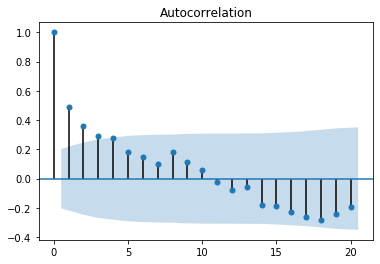

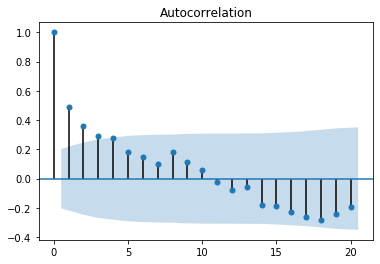

In [41]:
tp.plot_acf(yearly['Energy'],alpha=0.05)

In [36]:
if dryrun==False:
    daily.to_csv(output_data+out_prefix+'_pe_daily.csv')
    monthly.to_csv(output_data+out_prefix+'_pe_monthly.csv')
    yearly.to_csv(output_data+out_prefix+'_pe_yearly.csv')
    edc.to_csv(output_data+out_prefix+'_pe_percentiles.csv')
    monthly_day.to_csv(output_data+out_prefix+'_pe_monthly_day.csv')
    daily_slim.to_csv(output_data+out_prefix+'_pe_daily_slim.csv')
    weekly.to_csv(output_data+out_prefix+'_pe_weekly.csv')
    weekly_slim.to_csv(output_data+out_prefix+'_pe_weekly_slim.csv')
    calmonthly.to_csv(output_data+out_prefix+'_pe_calmonthly.csv')
    fdc.to_csv(output_data+out_prefix+'_pe_fdc.csv')
    power_exceed.to_csv(output_data+out_prefix+'_pe_power_exceed.csv')
    autocorrel.to_csv(output_data+out_prefix+'_pe_autocorrel.csv')
    models.to_csv(input_data + "models.csv")